In [5]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import spacy
nlp = spacy.load("en_core_web_sm")
import itertools

In [6]:
# Importing cleaned dataset
wikihow = pd.read_csv('./datasets/clean_wikihow_sep.csv')

## Surface Features

Surface features are usually features based on structure of documents or sentences like position in document or paragraph, length (number of words in the sentence) or number of quoted words in a sentence. This comes with the intuition that sentences are more important is the number of words with theh exception of stopwords is within a certain range x or the sentences containing too many quoted words are less important. 

In [7]:
wikihow = wikihow[['text_id', 'sentence', 'is_summary', 'words', 'title', 'sentence_len']]

In [8]:
wikihow.head()

,text_id,sentence,is_summary,words,title,sentence_len
0,0,Sell yourself first,yes,"['Sell', 'yourself', 'first']",How to Sell Fine Art Online,3
1,0,"Before doing anything else, stop and sum up yo...",no,"['Before', 'doing', 'anything', 'else,', 'stop...",How to Sell Fine Art Online,12
2,0,"Now, think about how to translate that to an o...",no,"['Now,', 'think', 'about', 'how', 'to', 'trans...",How to Sell Fine Art Online,11
3,0,"Be it the few words, Twitter allows you or an ...",no,"['Be', 'it', 'the', 'few', 'words,', 'Twitter'...",How to Sell Fine Art Online,21
4,0,Bring out the most salient features of your cr...,no,"['Bring', 'out', 'the', 'most', 'salient', 'fe...",How to Sell Fine Art Online,18


In [9]:
only_summaries = wikihow[wikihow['is_summary'] == 'yes']['sentence_len']

Text(0.5, 1.0, 'Distribution of sentence lengths')

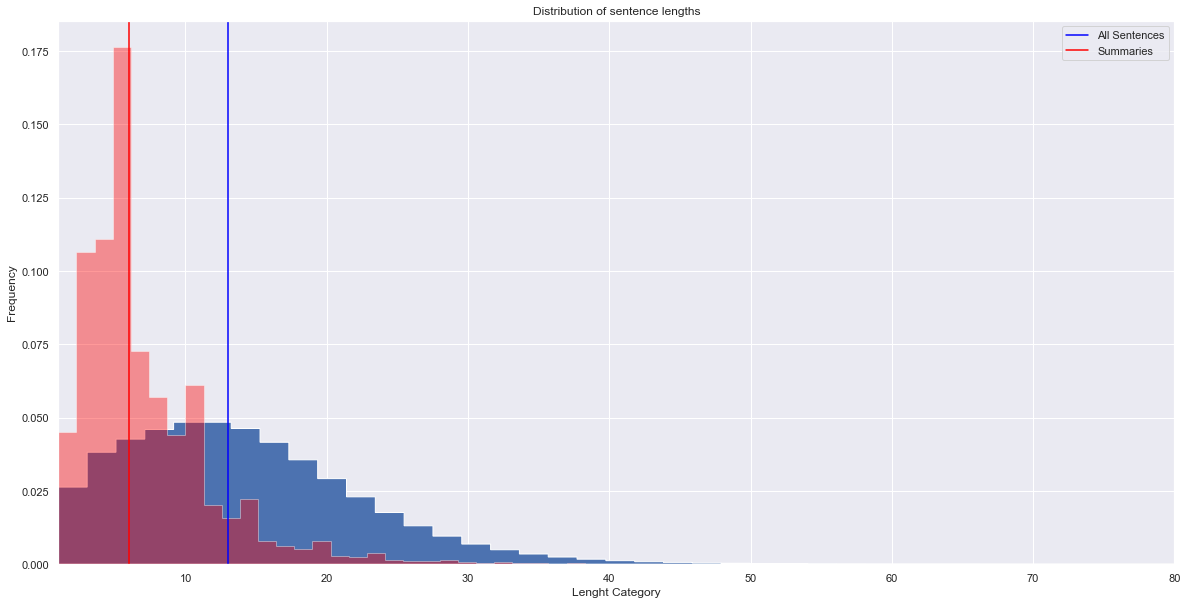

In [10]:
plt.figure(figsize=(20,10))
plt.hist(wikihow['sentence_len'],bins = 500, normed=True,histtype="stepfilled")
plt.hist(only_summaries,bins = 200, normed=True,histtype="stepfilled", color = 'red', alpha = 0.4)
plt.axvline(wikihow['sentence_len'].median(), color = 'blue')
plt.axvline(only_summaries.median(), color = 'red')
plt.xlim((1, 80)) 
plt.xlabel('Lenght Category')
plt.ylabel('Frequency')
plt.legend(['All Sentences','Summaries'],loc = 'upper right')
plt.title('Distribution of sentence lengths')

It looks like summary sentences are overall shorter than the rest of sentences

## Content Features
### Computing TF-IDF sentence scores
We will use tf-idf is used here to evaluate how important a sentence is in a document as well as compute the median tf-idf scores for summary sentences vs non-summary sentences. 

In [11]:
#extracting paragraphs
docs = wikihow.groupby('text_id')['sentence'].apply(list)

In [12]:
docs.head()

text_id
0    [Sell yourself first, Before doing anything el...
1    [Read the classics before 1600, Reading the cl...
2    [Join online artist communities, Depending on ...
3    [Make yourself public, Get yourself out there ...
4    [Blog about your artwork, Given the hundreds o...
Name: sentence, dtype: object

In [13]:
tf_idf_list = []
vectorizer = TfidfVectorizer()
for doc in docs:
    vectors = vectorizer.fit_transform(doc).toarray()
    for vector in vectors:
        tfidf_sent = np.sum(vector)
        tf_idf_list.append(tfidf_sent)
len(tf_idf_list)

7284000

In [14]:
wikihow['tfidf_score'] = tf_idf_list

In [15]:
wikihow.head()

,text_id,sentence,is_summary,words,title,sentence_len,tfidf_score
0,0,Sell yourself first,yes,"['Sell', 'yourself', 'first']",How to Sell Fine Art Online,3,1.725841
1,0,"Before doing anything else, stop and sum up yo...",no,"['Before', 'doing', 'anything', 'else,', 'stop...",How to Sell Fine Art Online,12,3.421057
2,0,"Now, think about how to translate that to an o...",no,"['Now,', 'think', 'about', 'how', 'to', 'trans...",How to Sell Fine Art Online,11,3.064425
3,0,"Be it the few words, Twitter allows you or an ...",no,"['Be', 'it', 'the', 'few', 'words,', 'Twitter'...",How to Sell Fine Art Online,21,4.393483
4,0,Bring out the most salient features of your cr...,no,"['Bring', 'out', 'the', 'most', 'salient', 'fe...",How to Sell Fine Art Online,18,3.500784


In [16]:
wikihow_subset = wikihow[:10000]
med_summary = wikihow_subset[wikihow_subset['is_summary'] == 'yes']['tfidf_score'].median()
med_no_summary = wikihow_subset[wikihow_subset['is_summary'] == 'no']['tfidf_score'].median()
med_summary, med_no_summary

(2.205039956914569, 3.6839863235570576)

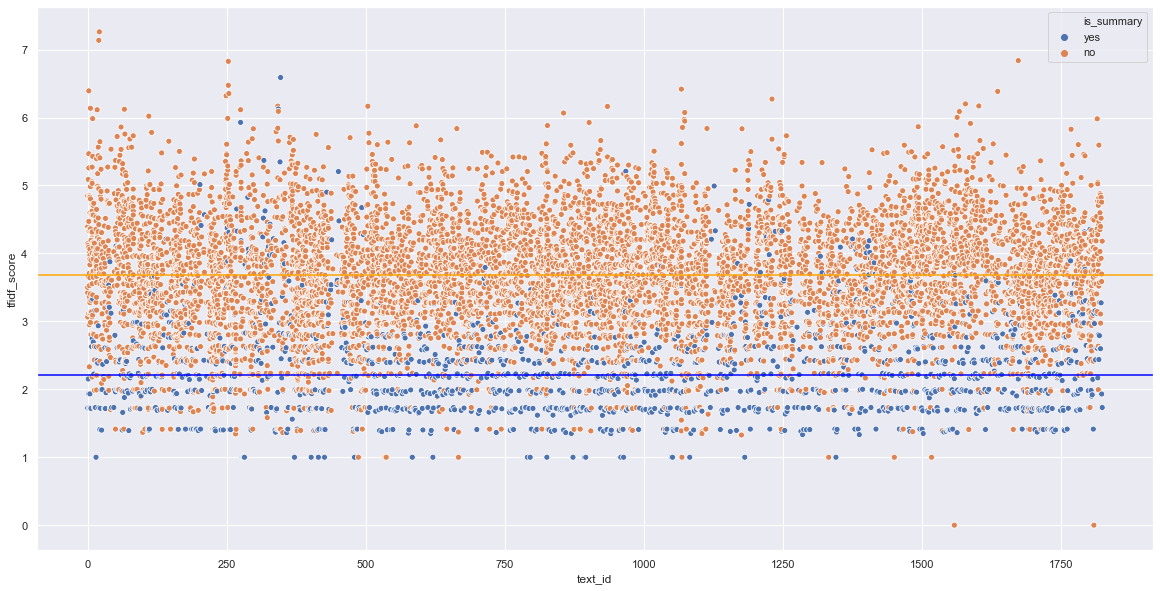

In [17]:
plt.figure(figsize=(20,10))
sns.scatterplot(y = 'tfidf_score', x = 'text_id', data = wikihow_subset, hue = 'is_summary')
plt.axhline(med_summary, color = 'blue')
plt.axhline(med_no_summary, color = 'orange')

Here it looks like sentences with the lowest tf-idf score are the ones that got picked as summary sentences. This can be due to the structure of the wikihow articles where the headline sometimes consists very little words. We will keep in mind that a wikihow article struucture is not representative of what a common text might be.

In [18]:
wikihow.to_csv('./datasets/wikihow_features_v1.csv')

## Relevance Features 

Another useful feature would be to use similarity to exploit intersentence relationship, the idea here is that sentences related to many other sentences are more relevant. and sentences with a better similarity to the title are important as well.

In [19]:
type(docs)

pandas.core.series.Series

In [20]:
docs_subset = docs.iloc[:10]

In [21]:
for document in docs_subset:
    print(document)

['Sell yourself first', 'Before doing anything else, stop and sum up yourself as an artist', 'Now, think about how to translate that to an online profile', 'Be it the few words, Twitter allows you or an entire page of indulgence that your own website would allow you', 'Bring out the most salient features of your creativity, your experience, your passion, and your reasons for painting', 'Make it clear to readers why you are an artist who loves art, produces high quality art, and is a true champion of art', 'If you re not great with words, find a friend who can help you with this really important aspect of selling online the establishment of your credibility and reliability']
['Read the classics before 1600', 'Reading the classics is the very first thing you have to do to be well read', 'If you want to build a solid foundation for your understanding of the books you read, then you can t avoid some of the earliest plays, poems, and oral tales ever written down', 'Remember that the novel d

In [ ]:
#print(permutations[119][0])

In [ ]:
sum([0.7534699073596656, 0.5668720214721069, 0.4256625335806633, 0.6024861561257847])/len([0.7534699073596656, 0.5668720214721069, 0.4256625335806633, 0.6024861561257847])

In [159]:
len(swap_list)

5

## Just create a similarity list for each sentence

In [29]:
for document in docs_subset:
    similarities = []
    for index, doc in enumerate(document):
        sims = list()
        for doc2 in document[index+1:]:
            sims.append(nlp(doc).similarity(nlp(doc2)))
        similarities.append(sims)
        
similarities

[[0.5046660583439553,
  0.500810440971552,
  0.37955766121939427,
  0.14913718510263926,
  0.3591656375782418,
  0.43546331867560356],
 [0.7320044141868878,
  0.6439920854744742,
  0.5603089109986917,
  0.7068383000338476,
  0.8065047047073178],
 [0.6024861561257847,
  0.4256625335806633,
  0.5668720214721069,
  0.7534699073596656],
 [0.6690540924022244, 0.8417177322409342, 0.7798425738995727],
 [0.7322545694057235, 0.660413859992843],
 [0.8067943006980787],
 []]

In [21]:
docs_subset

text_id
0      [Sell yourself first, Before doing anything el...
1      [Read the classics before 1600, Reading the cl...
2      [Join online artist communities, Depending on ...
3      [Make yourself public, Get yourself out there ...
4      [Blog about your artwork, Given the hundreds o...
5      [Create a mailing list, This could be your mos...
6      [Take good pictures, Like they say, a picture ...
7      [Be sure to properly license your art, Licensi...
8      [Consider the option of creating your own site...
9      [Expect this to be a gradual process and don t...
10     [Understand what a stage name can do for you, ...
11     [Examine your strengths as a performer, It s e...
12     [Write down what your weak points are, Yep, ti...
13     [Practice your material until you can perform ...
14     [Create a Ticketmaster account, This will enab...
15     [Practice, Being called by the muse is a wonde...
16     [Take a good look at your food budget, Restaur...
17     [Read the classi